In [4]:
!pip install urlextract wordcloud emoji Pillow ipywidgets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.8 MB/s eta 0:00:00


In [5]:
!pip install urlextract
from urlextract import URLExtract
from wordcloud import WordCloud
import pandas as pd
from collections import Counter
import string
import emoji
import PIL.Image
import numpy as np
import matplotlib.pyplot  as plt
import plotly.express as px
import re
import plotly.graph_objects as go
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
extract = URLExtract()

In [6]:
# Cleans and extracts date-related information from raw WhatsApp chat data.
def preprocess(data):
    df = pd.DataFrame()
    df['message'] = data['message'].astype(str).str.replace('\n', '')
    df['user'] = data['user']
    user_list=data['user'].tolist()
    month_mapping = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4,'May': 5, 'June': 6, 'July': 7, 'August': 8,'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    # Handle mixed month formats directly in pd.to_datetime
    df['date'] = pd.to_datetime(
        {
            'year': data['year'],
            'month': data['month'].map(month_mapping),
            'day': data['day'],
            'hour': data['hour'],
            'minute': data['minute']
        }
    )
    # Extract additional date-related information
    df['year'] = df['date'].dt.year
    df['month_name'] = df['date'].dt.month_name()
    df['month_num'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['hour'] = df['date'].dt.hour
    df['minute'] = df['date'].dt.minute
    df['only_date'] = df['date'].dt.date
    df['day_name'] = df['date'].dt.day_name()
    # Determine period of the day
    period = []
    for hour in df['hour']:
        if hour == 23:
            period.append(str(hour) + "-" + str('00'))
        elif hour == 0:
            period.append(str(hour) + "-" + str(hour + 1))
        else:
            period.append(str(hour) + "-" + str(hour + 1))
    df['period'] = period

    return df,user_list

# Extracts and categorizes unique users from a list.
#Also remove the group_notifications and adds Overall for entire stats of the group.

def get_unique_users(user_list):
    unique_users = []
    phone_numbers = []
    other_users = []

    # Create a set to store unique values
    unique_values = set()

    for user in user_list:
        if user == 'group_notification':
            continue
        elif user in unique_values:
            # Skip duplicate values
            continue
        else:
            unique_values.add(user)

        if re.match(r'^\+?\d+$', user):
            phone_numbers.append(user)
        else:
            other_users.append(user)

    phone_numbers = sorted(phone_numbers, key=lambda x: int(x.replace('+', '')))
    other_users.sort()

    unique_users = ['Overall'] + phone_numbers + other_users
    return unique_users

# Calculates message, word, media, and link counts for a selected user/Group.
def fetch_stats(selected_user,df):

    # used to  tell info about the selected user
    if selected_user != 'Overall':
        df = df[df['user'] == selected_user]

    # fetches the no of messages
    num_messages = df.shape[0]

    # fetches the total number of words
    words=[]
    for message in df['message']:
        words.extend(message.split())

    # fetches the number of media messages
    num_media_messages = df[df['message'] == '<Media omitted>'].shape[0]
    # no_media_messages = df['message'].str.contains('<Media omitted>', case=False).sum()

    # fetches the number of links shared
    links = []
    for message in df['message']:
        links.extend(extract.find_urls(message))

    return num_messages,len(words),num_media_messages,len(links)

#  Identifies top users based on message counts.
def most_busy_user(df):
    x = df['user'].value_counts().head()
    df = round((df['user'].value_counts() / df.shape[0]) * 100, 2).reset_index().rename(
        columns={'count': 'percent', 'user': 'name'})
    return x, df

# Generates a word cloud visualization for a selected user's/Groups messages.
def create_wordcloud(selected_user,df):
    image_path = "/content/WhatsApp_icon.png"
    python_mask = np.array(PIL.Image.open(image_path))
    if selected_user != 'Overall':
        df = df[df['user'] == selected_user]
    wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white',
                   contour_color='#c9eab8', contour_width=20,
                   mask=python_mask)
    df_wc = wc.generate(df['message'].str.cat(sep=" "))
    return df_wc

# Finds the most common words used by a selected user/Group
def most_common_words(selected_user, df):

    f = open('/content/stop_hinglish.txt', 'r')
    stop_words = f.read()

    if selected_user != 'Overall':
        df = df[df['user'] == selected_user]

    temp = df[df['user'] != 'group_notification']
    temp = df[~df['message'].str.contains('<Media omitted>')]

    words = []

    for messages in temp['message']:
        for word in messages.lower().split():
            word_without_punctuation = ''.join(char for char in word if char not in string.punctuation)
            if word_without_punctuation not in stop_words:
                words.append(word_without_punctuation)

    most_common_df = pd.DataFrame(Counter(words).most_common(20))
    return most_common_df

# Extracts and counts emojis used by a selected user
def emoji_helper(selected_user, df):
    if selected_user != 'Overall':
        df = df[df['user'] == selected_user]
    emojis = []
    for message in df['message']:
        emojis.extend([c for c in message if c in emoji.EMOJI_DATA])
    emoji_counter = Counter(emojis)
    emoji_df = pd.DataFrame(emoji_counter.most_common(10), columns=['Emoji', 'Count'])
    return emoji_df

# Creates a timeline of message counts per month for a selected user/Group
def monthly_timeline(selected_user, df):
    if selected_user != 'Overall':
        df = df[df['user'] == selected_user]

    monthly_timeline = df.groupby(['year', 'month_num', 'month_name']).count()['message'].reset_index()

    time = []
    for i in range(monthly_timeline.shape[0]):
        time.append(monthly_timeline['month_name'][i] + "-" + str(monthly_timeline['year'][i]))

    monthly_timeline['time'] = time
    return monthly_timeline;

# Creates a timeline of message counts per day for a selected user/Group.
def daily_timeline(selected_user, df):
    if selected_user != 'Overall':
        df = df[df['user'] == selected_user]

    daily_timeline = df.groupby('only_date').count()['message'].reset_index()

    return daily_timeline

# Creates a map of message counts per day of the week for a selected user/Group.
def week_activity_map(selected_user,df):
    if selected_user != 'Overall':
        df = df[df['user'] == selected_user]

    return df['day_name'].value_counts()

# Creates a map of message counts per month for a selected user/Group
def month_activity_map(selected_user, df):
    if selected_user != 'Overall':
        df = df[df['user'] == selected_user]

    return df['month_num'].value_counts()

#Creates a heatmap of message counts per day and time period for a selected user/Group
def activity_heatmap(selected_user, df):
    if selected_user != 'Overall':
        df = df[df['user'] == selected_user]

    user_heatmap = df.pivot_table(index='day_name', columns='period', values='message', aggfunc='count').fillna(0)
    return user_heatmap

In [7]:
# Retrieving Dataframe and the Userlist for the Stats Display.
whatsapp_df = pd.read_csv('/content/WhatsApp.csv')
df,user_list=preprocess(whatsapp_df)

In [62]:
df.head()

,message,user,date,year,month_name,month_num,day,hour,minute,only_date,day_name,period
0,Messages and calls are end-to-end encrypted. N...,group_notification,2021-03-27 00:00:00,2021.0,March,3.0,27.0,0.0,0.0,2021-03-27,Saturday,0.0-1.0
1,"Group creator created group ""JGEC MECH 2K17-21""",group_notification,2018-01-08 16:43:00,2018.0,January,1.0,8.0,16.0,43.0,2018-01-08,Monday,16.0-17.0
2,You were added,group_notification,2018-01-08 16:43:00,2018.0,January,1.0,8.0,16.0,43.0,2018-01-08,Monday,16.0-17.0
3,Keo clg jabi?,+91 95648 92981,2021-03-26 21:41:00,2021.0,March,3.0,26.0,21.0,41.0,2021-03-26,Friday,21.0-22.0
4,Kobe bol??,+91 6296 534 775,2021-03-26 21:46:00,2021.0,March,3.0,26.0,21.0,46.0,2021-03-26,Friday,21.0-22.0


<Axes: xlabel='date'>

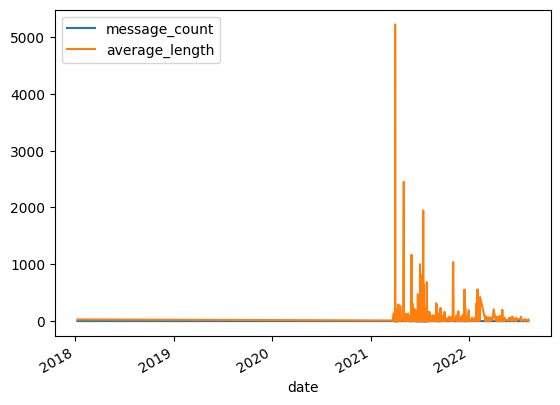

In [8]:
# @title Messages and Length over Time

df.groupby('date').agg(message_count=('message', 'count'), average_length=('message', lambda x: x.str.len().mean())).plot()

<Axes: xlabel='day_name'>

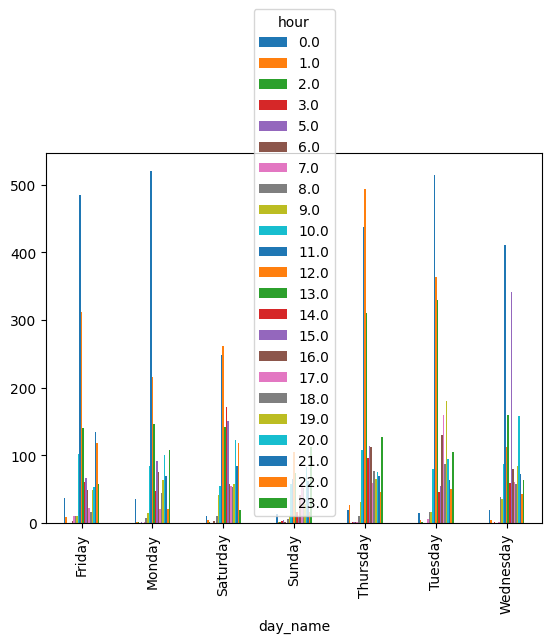

In [64]:
# @title Messages per hour by day of the week

df.groupby(['day_name', 'hour']).size().unstack().plot(kind='bar')

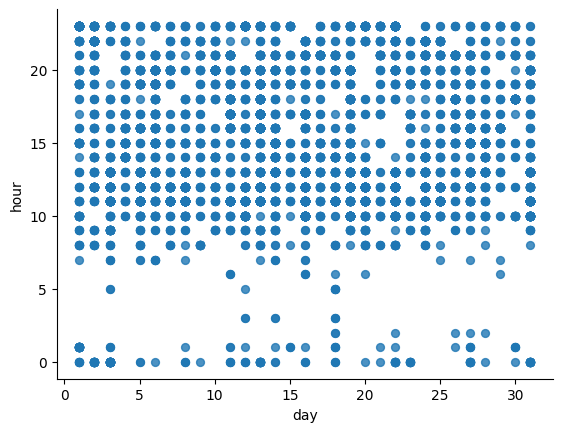

In [65]:
# @title day vs hour

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='day', y='hour', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [9]:
import re

def get_unique_users(user_list):
    unique_users = []
    phone_numbers = []
    other_users = []

    # Create a set to store unique values
    unique_values = set(user_list)

    for user in unique_values:
        if user == 'group_notification':
            continue

        user_str = str(user)  # Ensure the user is a string

        if re.match(r'^\+?\d+$', user_str):
            phone_numbers.append(user_str)
        else:
            other_users.append(user_str)

    phone_numbers = sorted(phone_numbers, key=lambda x: int(x.replace('+', '')))
    other_users.sort()

    unique_users = phone_numbers + other_users
    return unique_users

# Assuming 'user_list' is a list of users from your data
user_list = get_unique_users(user_list)
user_list.sort()
user_list.insert(0, 'Overall')

# Display widgets and handle button click events for analysis
import ipywidgets as widgets
from IPython.display import display

# Create a dropdown widget for selecting the user
selected_user_dropdown = widgets.Dropdown(
    options=user_list,
    description='Show analysis wrt:',
    disabled=False,
)

# Create a button widget for triggering the analysis
show_analysis_button = widgets.Button(
    description='Show Analysis',
    disabled=False,
    button_style='',  # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to show analysis',
    icon='',
)

# Output widget for displaying analysis results
output = widgets.Output()

# Function to display statistics based on the selected user
def display_statistics(selected_user):
    num_messages, words, num_media_messages, no_of_links = fetch_stats(selected_user, df)

    print("Top Statistics for", selected_user)
    print("Total Messages:", num_messages)
    print("Total Words:", words)
    print("Total Media:", num_media_messages)
    print("Total Links:", no_of_links)

# Function to handle button click event
def show_analysis(button):
    selected_user = selected_user_dropdown.value
    with output:
        output.clear_output()  # Clear previous output
        display_statistics(selected_user)

# Registering the event handler to the button
show_analysis_button.on_click(show_analysis)

# Display widgets
display(selected_user_dropdown)
display(show_analysis_button)
display(output)



Dropdown(description='Show analysis wrt:', options=('Overall', '+91 6290 954 522', '+91 6294 135 234', '+91 62…

Button(description='Show Analysis', style=ButtonStyle(), tooltip='Click to show analysis')

Output()

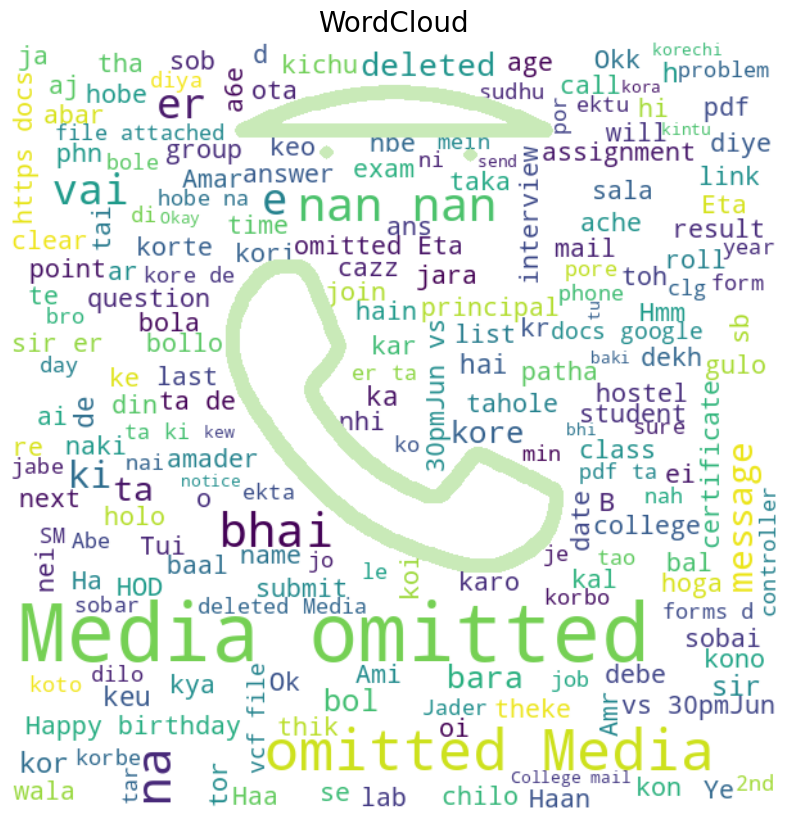

In [10]:
# WORDCLOUD
selected_user = selected_user_dropdown.value
df_wc = create_wordcloud(selected_user, df)
# Display the word cloud using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(df_wc, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title('WordCloud', fontsize=20)
plt.show()


In [11]:
import plotly.express as px

# Function to create a daily timeline plot
def daily_timeline(selected_user, df):
    if selected_user != 'Overall':
        df = df[df['user'] == selected_user]

    daily_timeline = df.groupby('only_date').count()['message'].reset_index()
    return daily_timeline

# Display the daily timeline using Plotly
selected_user = selected_user_dropdown.value
timeline = daily_timeline(selected_user, df)
fig = px.line(
    timeline,
    x='only_date',
    y='message',
    labels={'only_date': 'Date', 'message': 'Number of Messages'},
    title=f'Daily Timeline for {selected_user}',  # Dynamic title with user name
    markers=True  # Add markers to the line
)

# Update layout for better appearance
fig.update_layout(
    title={'text': f'Daily Timeline for {selected_user}', 'x':0.5, 'xanchor': 'center'},
    xaxis_title='Date',
    yaxis_title='Number of Messages',
    template='plotly_white',  # Use a clean white theme
    xaxis=dict(
        tickformat='%Y-%m-%d',  # Format the x-axis ticks
        tickangle=-45  # Angle the x-axis ticks for better readability
    )
)

# Show the figure
fig.show()



In [69]:
# monthly timeline
timeline = monthly_timeline(selected_user, df)
fig = px.line(timeline, x='time', y='message', labels={'message': 'Number of Messages'}, title="Monthly Timeline")
fig.show()

In [70]:
# activity monitor
#Busiest Day
busy_day = week_activity_map(selected_user,df)
fig=px.bar(busy_day,x=busy_day.index, y=busy_day.values, title="Most Busy Day")
fig.update_xaxes(title_text="Days in a Week")
fig.update_yaxes(title_text="Number of Messages")
fig.show()

In [49]:
import plotly.graph_objects as go

# Assuming busy_day is a Series with day names as index and message counts as values
busy_day = week_activity_map(selected_user, df)

# Radar chart for busiest day
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=busy_day.values,
    theta=busy_day.index,
    fill='toself',
    name='Busiest Day'
))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, busy_day.values.max()]
        )
    ),
    title="Most Busy Day (Radar Chart)"
)

fig.show()



In [50]:
#Busiest Month
busy_month = month_activity_map(selected_user,df)
fig=px.bar(busy_month,x=busy_month.index, y=busy_month.values,title="Most Busy Month")
fig.update_xaxes(title_text="Months in a Year")
fig.update_yaxes(title_text="Number of Messages")
fig.show()

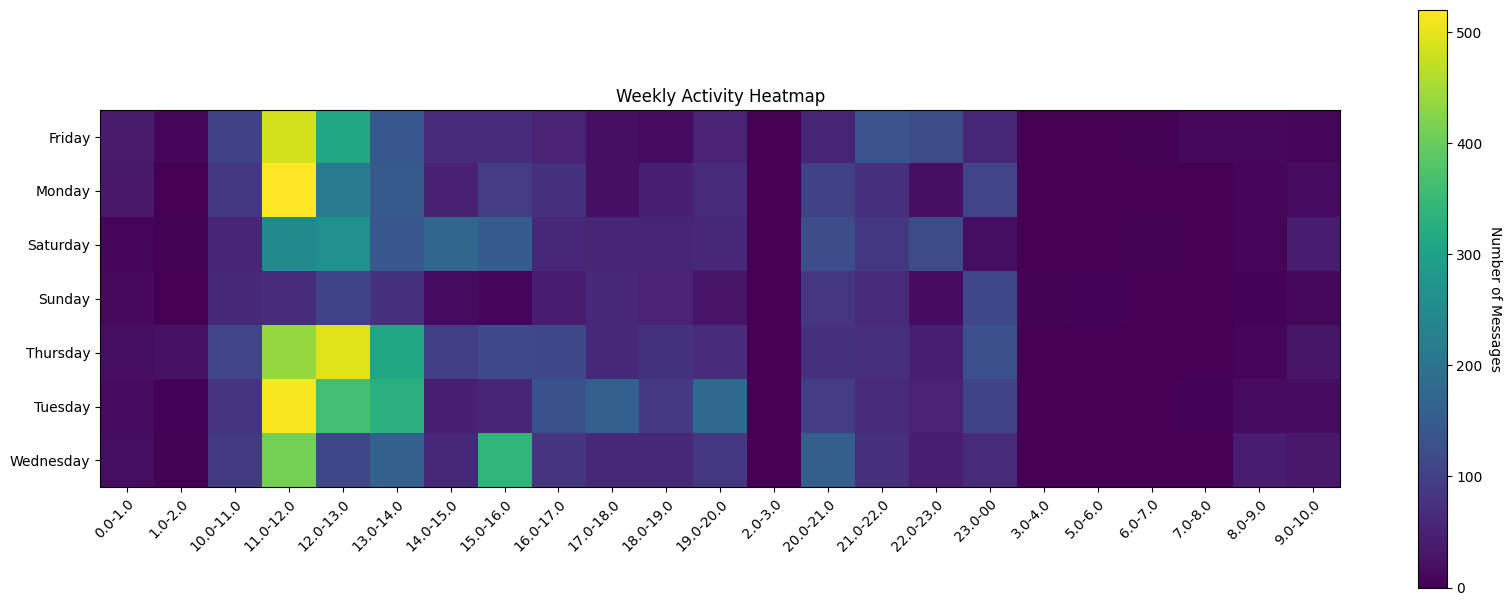

Most Busy Users
               name  percent
0         Debsrijan     6.28
1   +91 93313 11239     5.16
2       Sourav Kase     4.74
3           Sailesh     4.65
4   +91 90642 36011     4.35
..              ...      ...
68  +91 70636 99840     0.02
69  +91 99324 04743     0.02
70  +91 95474 72559     0.02
71  +91 90831 68118     0.01
72  +91 95478 59196     0.01

[73 rows x 2 columns]


In [71]:
# Heatmap Weekly
user_heatmap = activity_heatmap(selected_user, df)
fig, ax = plt.subplots(figsize=(20, 15))
heatmap = ax.imshow(user_heatmap, cmap='viridis')

# Set labels
ax.set_xticks(range(len(user_heatmap.columns)))
ax.set_yticks(range(len(user_heatmap.index)))
ax.set_xticklabels(user_heatmap.columns)
ax.set_yticklabels(user_heatmap.index)

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
cbar = ax.figure.colorbar(heatmap, ax=ax,shrink=0.5)
cbar.ax.set_ylabel("Number of Messages", rotation=-90, va="bottom")

# Set title
ax.set_title("Weekly Activity Heatmap")
plt.show()
# finding the busiest user in the group(Group level)
if selected_user == 'Overall':
    print('Most Busy Users')
    x, new_df =most_busy_user(df)
    print(new_df)
    fig = px.bar(x,x=x.index,y=x.values, labels={'y':'Number of Messages'},title="Most Busy Users")
    fig.show()

In [53]:
# most common words without punctuation marks
most_common_df = most_common_words(selected_user, df)
fig=px.bar(most_common_df, x=1, y=0,orientation='h',labels={'x': 'Number of Occurrences'})
fig.update_traces(marker_color='#575fe8')
fig.update_layout(title="Most Common Words")
fig.show()

In [73]:
# Emoji analysis
emoji_df = emoji_helper(selected_user, df)
print(emoji_df)

  Emoji  Count
0     😂    691
1     🤣    552
2     ❤    126
3     🏻    118
4     👍    114
5     🔥     91
6     🎉     89
7     😅     83
8     🥲     63
9     😑     56


In [12]:
# emoji analysis
emoji_df = emoji_helper(selected_user, df)
fig = go.Figure(data=[go.Pie(labels=emoji_df['Emoji'], values=emoji_df['Count'])])
fig.update_layout(title_text='Top 10 Emoji Analysis')
fig.show()

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix, silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import nltk

# Download the VADER lexicon
nltk.download('vader_lexicon')

# Assuming 'df' is your DataFrame and it has a 'message' and 'sentiment' column
# If 'sentiment' column does not exist, you need to create it based on your criteria
# Here we assume df['sentiment'] exists and contains 0 and 1 values for negative and positive sentiments

# Load Hinglish stop words
with open('stop_hinglish.txt', 'r') as f:
    hinglish_stop_words = f.read().splitlines()

# Ensure the stop words are tokenized consistently with the TfidfVectorizer
hinglish_stop_words = [word.strip().lower() for word in hinglish_stop_words]

# Vectorize the messages with Hinglish stop words
vectorizer = TfidfVectorizer(stop_words=hinglish_stop_words)
X = vectorizer.fit_transform(df['message'].astype(str))

# Extract labels
if 'sentiment' not in df.columns:
    # Example: create 'sentiment' column with random 0s and 1s (you should use your actual sentiment data)
    np.random.seed(42)
    df['sentiment'] = np.random.randint(0, 2, df.shape[0])

y = df['sentiment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['don', 'mon'] not in stop_words.



Naive Bayes Accuracy: 0.4870305845915602
              precision    recall  f1-score   support

    Negative       0.51      0.31      0.39      1336
    Positive       0.48      0.67      0.56      1247

    accuracy                           0.49      2583
   macro avg       0.49      0.49      0.47      2583
weighted avg       0.49      0.49      0.47      2583



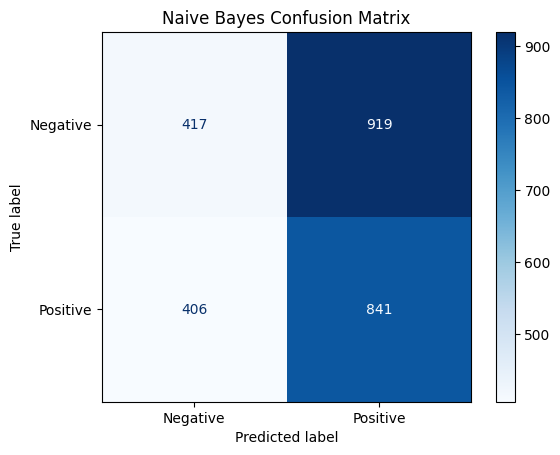

In [34]:
# Naive Bayes Classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {accuracy_nb}")
print(classification_report(y_test, y_pred_nb, target_names=['Negative', 'Positive']))
confusion_matrix_nb = confusion_matrix(y_test, y_pred_nb)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_nb, display_labels=['Negative', 'Positive']).plot(cmap=plt.cm.Blues)
plt.title('Naive Bayes Confusion Matrix')
plt.show()


KNN Accuracy: 0.518776616337592
              precision    recall  f1-score   support

    Negative       0.52      0.85      0.65      1336
    Positive       0.50      0.17      0.25      1247

    accuracy                           0.52      2583
   macro avg       0.51      0.51      0.45      2583
weighted avg       0.51      0.52      0.45      2583



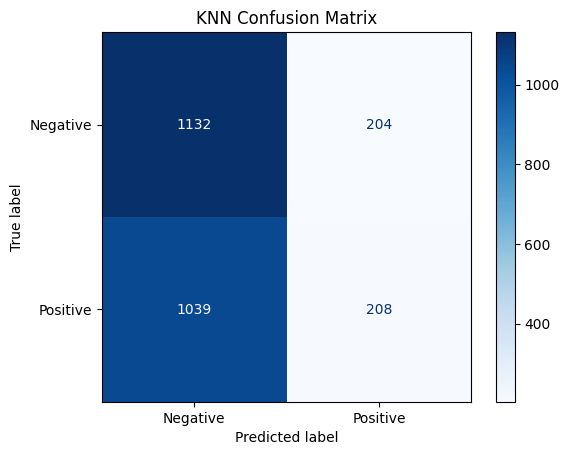

In [35]:

# K-Nearest Neighbors (KNN) Classifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {accuracy_knn}")
print(classification_report(y_test, y_pred_knn, target_names=['Negative', 'Positive']))
confusion_matrix_knn = confusion_matrix(y_test, y_pred_knn)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_knn, display_labels=['Negative', 'Positive']).plot(cmap=plt.cm.Blues)
plt.title('KNN Confusion Matrix')
plt.show()



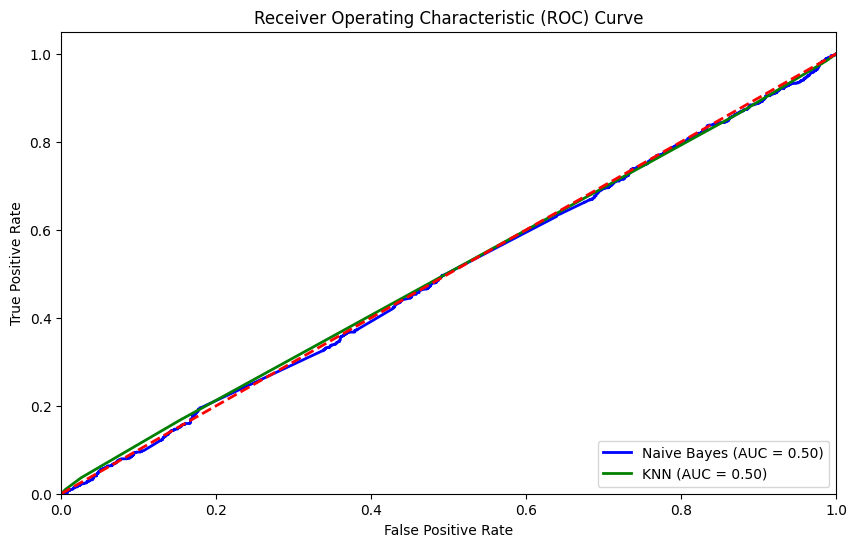

In [36]:
# Calculate ROC Curve and AUC for Naive Bayes
y_pred_nb_prob = nb_model.predict_proba(X_test)[:, 1]
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_nb_prob)
roc_auc_nb = auc(fpr_nb, tpr_nb)

# Calculate ROC Curve and AUC for KNN
y_pred_knn_prob = knn_model.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_knn_prob)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plot ROC Curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_nb, tpr_nb, color='blue', lw=2, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')
plt.plot(fpr_knn, tpr_knn, color='green', lw=2, label=f'KNN (AUC = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



In [37]:
# Elbow Method for Optimal K in K-Means Clustering
sse = []
silhouette_scores = []
for k in range(2, 11):  # Start from 2 to calculate silhouette score
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

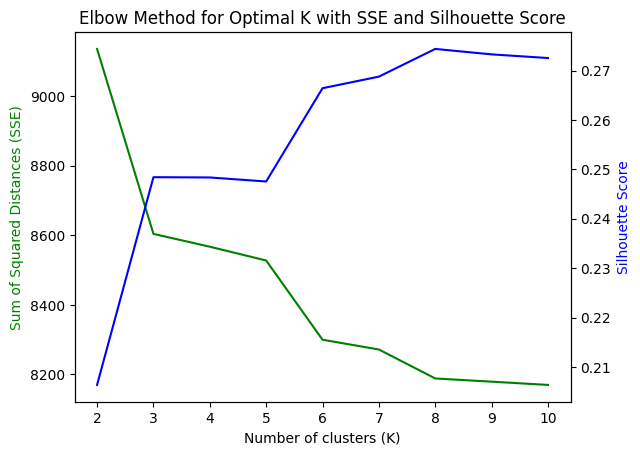

In [38]:
# Plot SSE and Silhouette Score
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(range(2, 11), sse, 'g-')
ax2.plot(range(2, 11), silhouette_scores, 'b-')

ax1.set_xlabel('Number of clusters (K)')
ax1.set_ylabel('Sum of Squared Distances (SSE)', color='g')
ax2.set_ylabel('Silhouette Score', color='b')

plt.title('Elbow Method for Optimal K with SSE and Silhouette Score')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



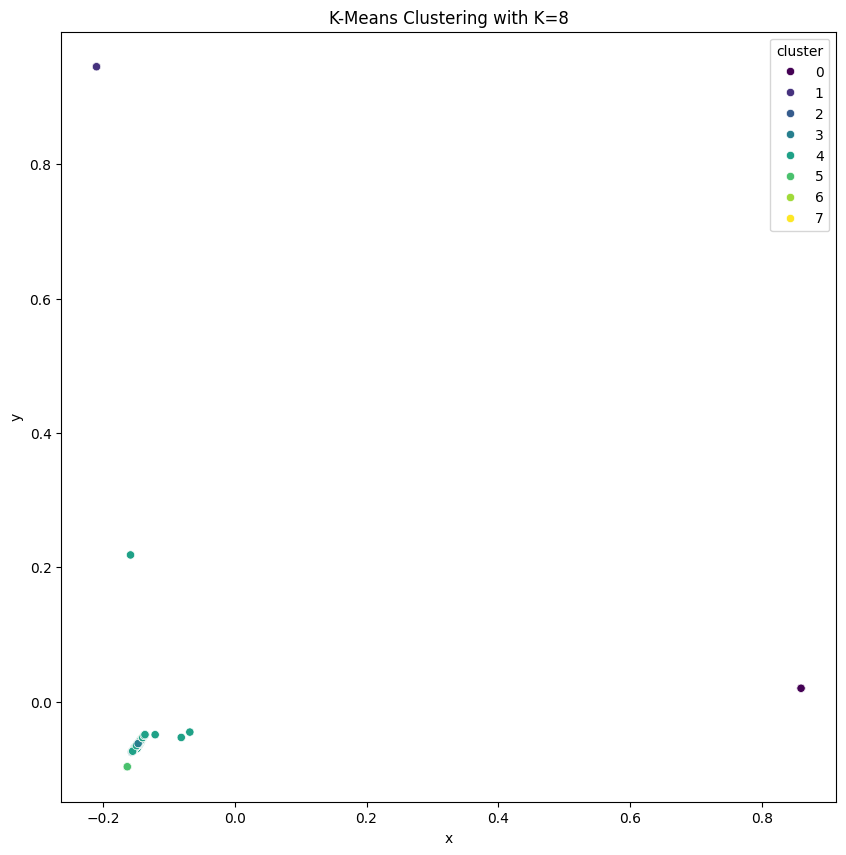

In [39]:

# Determine the optimal K (using silhouette score for example)
optimal_k = np.argmax(silhouette_scores) + 2  # Adding 2 because range starts from 2

# Apply K-Means with the optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Reduce dimensions for visualization using PCA
pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(X.toarray())

df['x'] = scatter_plot_points[:, 0]
df['y'] = scatter_plot_points[:, 1]

plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='x', y='y', hue='cluster', palette='viridis', legend='full')
plt.title(f'K-Means Clustering with K={optimal_k}')
plt.show()

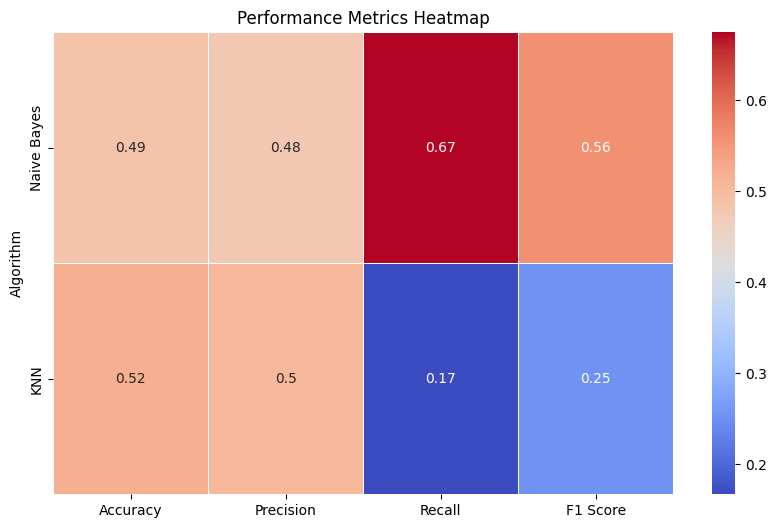

In [40]:

# Extract labels
if 'sentiment' not in df.columns:
    # Example: create 'sentiment' column with random 0s and 1s (you should use your actual sentiment data)
    np.random.seed(42)
    df['sentiment'] = np.random.randint(0, 2, df.shape[0])

y = df['sentiment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize dictionaries to store the performance metrics
performance_metrics = {
    'Algorithm': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

# Function to calculate and store performance metrics
def store_metrics(algorithm_name, y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    performance_metrics['Algorithm'].append(algorithm_name)
    performance_metrics['Accuracy'].append(accuracy)
    performance_metrics['Precision'].append(precision)
    performance_metrics['Recall'].append(recall)
    performance_metrics['F1 Score'].append(f1)

# Naive Bayes Classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
store_metrics('Naive Bayes', y_test, y_pred_nb)

# K-Nearest Neighbors (KNN) Classifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
store_metrics('KNN', y_test, y_pred_knn)

# Convert performance metrics dictionary to DataFrame
performance_df = pd.DataFrame(performance_metrics)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(performance_df.set_index('Algorithm'), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Performance Metrics Heatmap')
plt.show()
